# Water Observations from Space (WOFS)

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is significantly better than the Landsat QA water flag or the NDWI index for water identification. 
<br><br>
For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr  

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Select and view the analysis region

In [2]:
## LS8 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '2013-04-13', '2018-03-26'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS8 Vietnam
# Latitude:  (10.513927001104687, 12.611133863411238)  
# Longitude: (106.79005909290998, 108.91906631627438)  
# '2014-01-14', '2016-12-21'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '1999-08-21', '2018-03-25'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Lake Baringo
# Latitude:  (0.4997747685, 0.7495947795)  
# Longitude: (35.9742163305, 36.473586859499996)  
# '2005-01-08', '2016-12-24'
# Resolution: (-0.000269493, 0.000269493)

In [3]:
output_crs = 'EPSG:4326'
resolution = (-0.000269494585236, 0.000269494585236)

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select an analysis region (Lat-Lon) within the extents listed above. 
# Be sure you check whether you are using L7 or L8 as the time extents are very different
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the water assessment

# Kenya - LS7
#latitude = (0.49964002, 0.7495)
#longitude = (36.0, 36.15)
#time_extents = ('2000-01-01', '2018-01-01')
#product = 'ls7_collection1_AMA_ingest'
#platform = "LANDSAT_7"

#Sub-region selection - Colombia
latitude = (1.0684, 0.8684)
longitude  = (-74.8409, -74.6409)
time_extents = ('2000-01-01', '2018-01-01')
product = 'ls8_collection1_AMA_ingest'
platform = "LANDSAT_8"

In [5]:
# The code below renders a map that can be used to view the analysis region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

## Load the dataset and the required spectral bands or other parameters
After loading, you will view the Xarray dataset. Notice the dimensions represent the number of pixels in your latitude and longitude dimension as well as the number of time slices (time) in your time series.

In [6]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          output_crs=output_crs,
                          resolution=resolution,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
# View some of the content in the xarray dataset
# The latitude and longitude dimensions are in pixels
# The time reflects the number of time slices in the xarray
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 743, longitude: 743, time: 48)
Coordinates:
  * time       (time) datetime64[ns] 2013-05-06T15:15:22 2013-06-07T15:15:34 ...
  * latitude   (latitude) float64 1.068 1.068 1.068 1.068 1.067 1.067 1.067 ...
  * longitude  (longitude) float64 -74.84 -74.84 -74.84 -74.84 -74.84 -74.84 ...
Data variables:
    red        (time, latitude, longitude) int16 2457 2277 2212 2320 2412 ...
    green      (time, latitude, longitude) int16 2549 2388 2337 2432 2535 ...
    blue       (time, latitude, longitude) int16 2484 2298 2211 2320 2379 ...
    nir        (time, latitude, longitude) int16 4441 4291 4221 4304 4371 ...
    swir1      (time, latitude, longitude) int16 3193 3052 3053 3080 3173 ...
    swir2      (time, latitude, longitude) int16 2335 2211 2199 2230 2315 ...
    pixel_qa   (time, latitude, longitude) int32 480 480 480 480 480 480 480 ...
Attributes:
    crs:      EPSG:4326

>### Masking out Clouds

In [8]:
cloud_mask = np.bitwise_and(landsat_dataset.pixel_qa,6).astype(bool)
cleaned_dataset = landsat_dataset.drop('pixel_qa').where(cloud_mask)

## Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [9]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset,clean_mask = cloud_mask)

In [10]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

# Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

In [11]:
# import color-scheme and set nans to black
from matplotlib.cm import jet_r as jet_r
jet_r.set_bad('black',1)

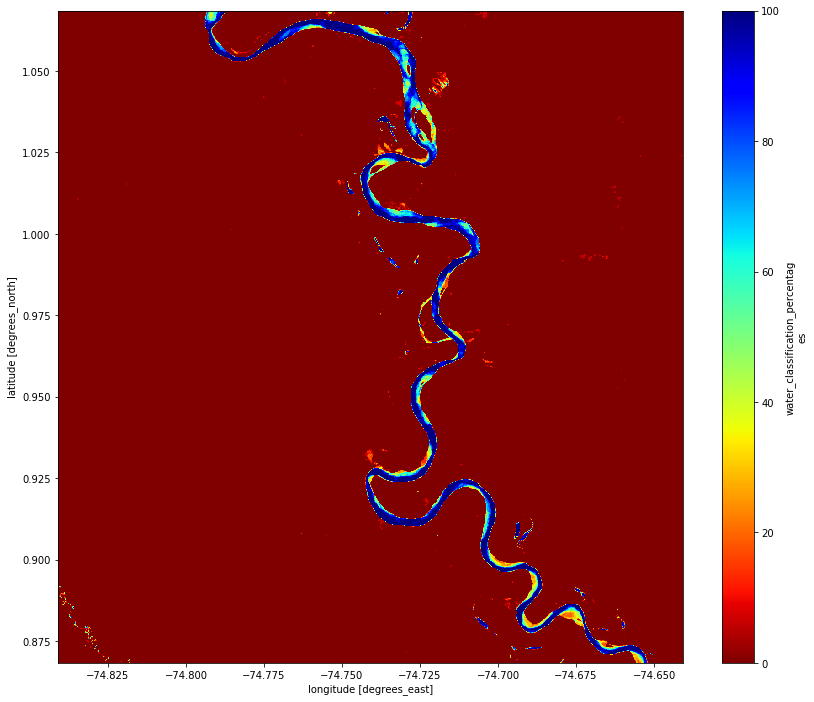

In [12]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# This is where the WOFS time series product is generated. 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

# The "figsize" may need adjustment to get the proper scaling and avoid distortion. 
# See the XARRAY dimensions above to get an idea of the Lat-Lon ratio for your image, figsize=(x,y)
# The y-axis scale and legend is part of the image area, so that needs to be considered
# It is suggested to keep the x-dimension at x=12. 

water_classification_percentages.plot(cmap = jet_r, figsize=(14,12))

The following code computes and then plots the percentage of valid pixels that were identified as water, for each time step in the time series. It should be noted that clouds can impact the statistical results.

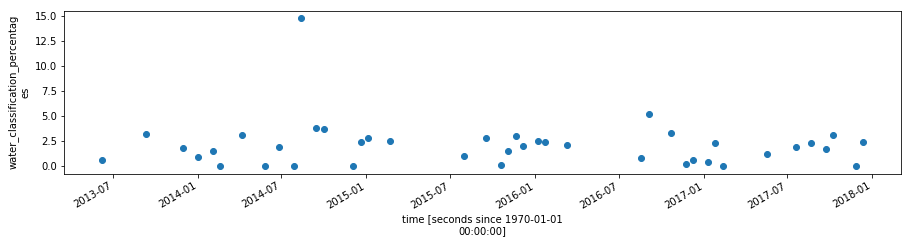

In [13]:
water_classification_mean_percentages = (ts_water_classification.mean(dim = ['latitude','longitude']) * 100).wofs.rename('water_classification_percentages')
water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')

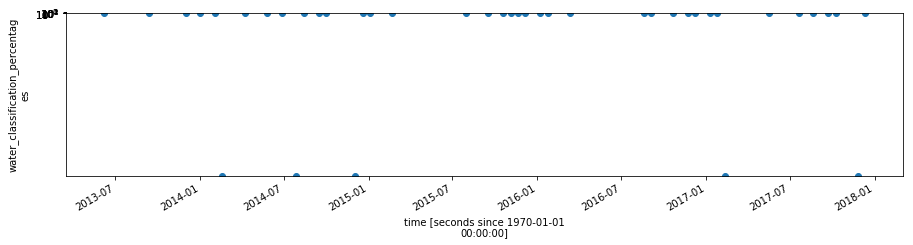

In [14]:
# The Y-scaling has been changed to logarithmic for the time series percentage plot
# The result below can be compared to the result above. 

water_classification_mean_percentages.plot(figsize=(15,3), marker='o', linestyle='None')
plt.gca().set_yscale('log') # Change scaling of the Y axis to logarithmic

In [15]:

# Save the water percentage data to a GeoTIFF
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

# ts_water_classification
dataset_to_export = xr.Dataset(coords=water_classification_percentages.coords,attrs=ts_water_classification.attrs)
dataset_to_export['wofs_pct'] = (water_classification_percentages/100).astype(np.float32)
print(dataset_to_export)

<xarray.Dataset>
Dimensions:    (latitude: 743, longitude: 743)
Coordinates:
  * latitude   (latitude) float64 1.068 1.068 1.068 1.068 1.067 1.067 1.067 ...
  * longitude  (longitude) float64 -74.84 -74.84 -74.84 -74.84 -74.84 -74.84 ...
Data variables:
    wofs_pct   (latitude, longitude) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [16]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>>>>>>

# The export command on the following line is commented out to avoid overwriting files. 
# If you would like to export data, please change the filename before uncommenting the next line.
# export_slice_to_geotiff(dataset_to_export, 'geotiffs/WOFS_Percentage_demo.tif')

In [17]:
!ls -lah geotiffs/

total 2.9M
drwxrwsr-x 2 1000 users 4.0K Jan 14 04:40 .
drwxrwsr-x 6 1000 users 4.0K Jan 14 11:23 ..
-rw-rw-r-- 1 1000 users 1.7M Jan 14 00:16 DEMO_median_composite.tif
-rw-rw-r-- 1 1000 users 1.2M Jan 14 04:40 WOFS_Percentage_demo.tif
